In [1]:
import algorithms.train as train
import algorithms.utils as utils
import algorithms.models as models
from enviroments import env_red, env_red_p2p, env_red_toy1, env_hubs1
from algorithms.agents import reinforce
import matplotlib.pyplot as plt
import numpy as np
import torch
import gym

In [2]:
env = env_hubs1(model="Exp", T=2000)
M = 33
F = 2

#Dimensiónes del espacio de estados
dims_state = list(env.C + 1)
dims_state.append(env.T+1)

#Dimensiones del espacio de acciones
dims_action = [M, F]


In [3]:
dimensions_actor = dims_state + dims_action
dimensions_critic = dims_state

freq = 5000

lr_actor = 1e-5

k = 5

In [4]:
actor = models.PolicyPARAFAC(dimensions_actor, k=k, model= "SoftMax", scale = 1)
critc = models.ValuePARAFAC(dimensions_critic, k=k, scale = 1)

In [5]:

agent = reinforce.ReinforceSoftmaxNN(actor, critc, gamma=.99, tau=.99, lr_actor= 1e-6)
Trainer = train.Trainer("sgd", "sgd")


In [8]:
_, totals,_ = Trainer.train(env, agent, epochs=5000, max_steps=2000, update_freq=8000, initial_offset=0)

/home/jorejuela/Code/RMS/algorithms/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices=torch.tensor(indices,dtype=torch.long)


/home/jorejuela/Code/RMS/algorithms/models.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices=torch.tensor(indices,dtype=torch.long)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'LRQL-Returns de 10 trayectorias cada 100 episodios')

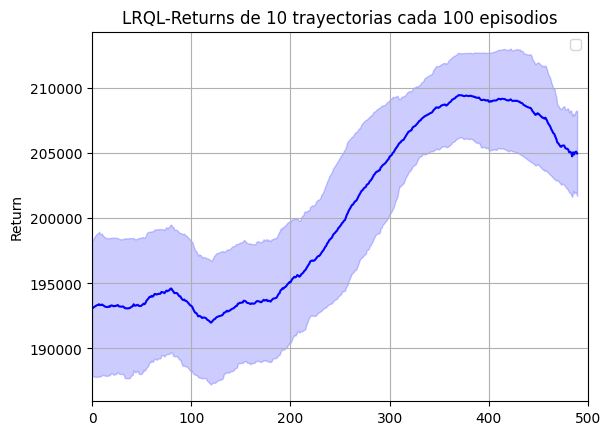

In [11]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(1)

Rs = np.array(totals).ravel()

mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b')
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)

plt.xlim(0, len(Rs))
plt.grid()
plt.ylabel("Return")
plt.legend()
plt.title("PG-Returns de 10 trayectorias cada 100 episodios")
    


In [ ]:
def forward(self, indices: np.ndarray) -> torch.Tensor:
        prod = torch.ones(self.k, dtype=torch.double)
        for i in range(len(indices)):
            idx = indices[i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if len(indices) < len(self.factors):
            res = []
            for cols in zip(
                *[self.factors[-(a + 1)].t() for a in reversed(range(self.nA))]
            ):
                kr = cols[0]
                for j in range(1, self.nA):
                    kr = torch.kron(kr, cols[j])
                res.append(kr)
            factors_action = torch.stack(res, dim=1)
            return torch.matmul(prod, factors_action.T)
        return torch.sum(prod, dim=-1)